<a href="https://colab.research.google.com/github/tjens150/ML_practice/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variatonal Autoencoder
Experimenting with developing a variational autoencoder to generate synthetic spectra of stars.

In [2]:
import numpy as np
from astropy.io import fits
import pylab as plt # only needed for verification

Preparing to load stellar spectra from SDSS' Apogee telescope. Data loading is thanks to David W. Hogg at NYU

In [6]:
# construct url to the file of labels and read it
base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/"
fn = "allStarLite-dr17-synspec_rev1.fits"
allstar = fits.open(base_url + fn)
for a in allstar:
    print(a)

In [ ]:
# the labels are in an enormous table in element [1] of this FITS file
labels = allstar[1].data
plt.scatter(labels['TEFF'], labels['LOGG'], s=1)
plt.xlim(6000, 3500)
plt.ylim(5, 0)

Pick out standard red-giant-branch stars.

In [ ]:
# make a reasonable red-giant-branch sample
RGB = True
RGB = np.logical_and(RGB, labels['TEFF'] > 3500.)
RGB = np.logical_and(RGB, labels['TEFF'] < 5400.)
RGB = np.logical_and(RGB, labels['LOGG'] < 3.0)
RGB = np.logical_and(RGB, labels['LOGG'] > 0.0)
RGB = np.logical_and(RGB, labels['H'] < 10.5)
print(np.sum(RGB))

In [ ]:
# make a plot that an astronomer likes to see
RGB_labels = labels[RGB]
plt.scatter(RGB_labels['TEFF'], RGB_labels['LOGG'], c=RGB_labels['FE_H'], s=1)
plt.xlim(5400, 3500)
plt.xlabel("effective temperature")
plt.ylim(3., 0.)
plt.ylabel("log10 surface gravity")
plt.colorbar(label="metallicity")

In [ ]:
# make train, validation, and test data sets
rng = np.random.default_rng(17)
N_RGB = len(RGB_labels)
N_train, N_valid, N_test = 1024, 256, 512
I = rng.permutation(N_RGB)
I_train = I[0:N_train]
I_valid = I[N_train:N_train+N_valid]
I_test = I[N_train+N_valid:N_train+N_valid+N_test]
train_labels = RGB_labels[I_train]
valid_labels = RGB_labels[I_valid]
test_labels = RGB_labels[I_test]
print(len(train_labels), len(valid_labels), len(test_labels))

In [ ]:
# Plot the labels of the three data sets
# make a plot that an astronomer likes to see
for l, t in [(train_labels, "Training Set"),
             (valid_labels, "Validation Set"),
             (test_labels, "Test Set")]:
    plt.figure()
    plt.title(t)
    plt.scatter(l['TEFF'], l['LOGG'], c=l['FE_H'], s=1)
    plt.xlim(5400, 3500)
    plt.xlabel("effective temperature")
    plt.ylim(3., 0.)
    plt.ylabel("log10 surface gravity")
    plt.colorbar(label="metallicity")

This part of the code actually loads in the spectra of each star we have selected given the criteria above (red-giant-branch).

In [ ]:
# now time to read the spectral data - the features - this HURTS
def get_features(labels):
    features = None
    for l in labels:
        url = base_url + l['TELESCOPE'] + "/" + l['FIELD'] + "/aspcapStar-dr17-" + l['APOGEE_ID'] + ".fits"
        x = fits.open(url)[1].data
        if features is None:
            features = x[None, :]
        else:
            features = np.concatenate((features, x[None, :]), axis=0)
    return features

In [10]:
# This will take a while, the first time you run it. Don't be alarmed.
train_features = get_features(train_labels)
valid_features = get_features(valid_labels)
test_features = get_features(test_labels)
print(train_features.shape, valid_features.shape, test_features.shape)

(1024, 8575) (256, 8575) (512, 8575)


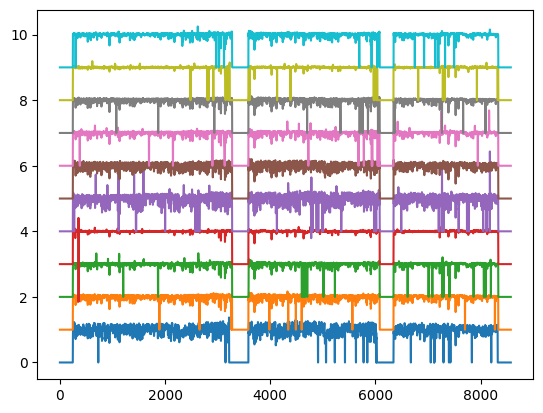

In [11]:
for i in range(10):
    plt.plot(train_features[i] + i)

In [ ]:
pip install --upgrade tensorflow

In [18]:
import tensorflow as tf
import pandas as pd
#from sklearn.preprocessing import StandardScaler

#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(1)

# MLP
Start off seeing how a basic MLP fares in predicting labels (surface gravity of stars)

In [51]:
def create_dataset(feat,labels,batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((feat, labels))
    return dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(1)
batch_size=32


In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels['LOGG']))
for line in train_dataset.take(5):
  print(line)


(<tf.Tensor: shape=(8575,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5848838>)
(<tf.Tensor: shape=(8575,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>, <tf.Tensor: shape=(), dtype=float32, numpy=2.4330904>)
(<tf.Tensor: shape=(8575,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>, <tf.Tensor: shape=(), dtype=float32, numpy=2.334861>)
(<tf.Tensor: shape=(8575,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>, <tf.Tensor: shape=(), dtype=float32, numpy=2.5470772>)
(<tf.Tensor: shape=(8575,), dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>, <tf.Tensor: shape=(), dtype=float32, numpy=0.52421606>)


In [52]:
train_set=create_dataset(train_features,train_labels['LOGG'])
valid_set=create_dataset(valid_features,valid_labels['LOGG'])
test_set=create_dataset(test_features,test_labels['LOGG'])

In [33]:
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)])

In [34]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
norm_layer.adapt(train_features)

In [35]:
MLP_hist=model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.6176 - val_loss: 1.1616
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7219 - val_loss: 0.7339
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3336 - val_loss: 0.7610
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1208 - val_loss: 0.6393
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1181 - val_loss: 0.6264
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1308 - val_loss: 0.6260
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1035 - val_loss: 0.6054
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1053 - val_loss: 0.6092
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1181 - val_loss: 0.5737
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.1042 - val_loss: 0.5723
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1464 - val_loss: 0.5799
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1

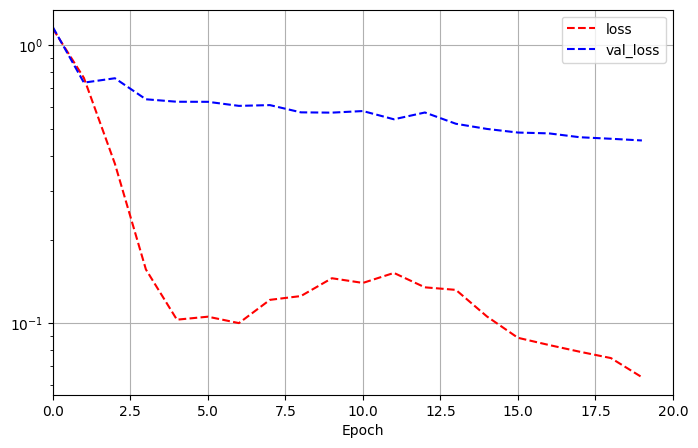

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(MLP_hist.history).plot(
figsize=(8, 5), xlim=[0, 20], logy=True, grid=True, xlabel="Epoch",
 style=["r--", "b--"])
plt.show()

# CNN:
Seeing how well a CNN fares to implement in the VAE

In [63]:
mfeat=train_features.shape[-1]

In [65]:
filters=[5,10,20,30]
kernel_sizes=[3,3,3,3]
strides=[1,1,1,1]
def create_CNN_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv1D(filters=filters[0],kernel_size=kernel_sizes[0],strides=strides[0],padding='same',input_shape=(None,mfeat,1)))
    model.add(tf.keras.layers.AvgPool1D(pool_size=2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    for i in range(len(filters)-1):
      model.add(tf.keras.layers.Conv1D(filters=filters[i+1],kernel_size=kernel_sizes[i+1],strides=strides[i+1],padding='same'))
      model.add(tf.keras.layers.AvgPool1D(pool_size=2))
      model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

CNN_model = create_CNN_model()
CNN_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
def create_dataset(feat,labels,batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((feat[:,:,None], labels))
    return dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(1)
train_set=create_dataset(train_features,train_labels['LOGG'])
valid_set=create_dataset(valid_features,valid_labels['LOGG'])
test_set=create_dataset(test_features,test_labels['LOGG'])

In [67]:
CNN_hist=CNN_model.fit(train_set, epochs=20, validation_data=valid_set)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - loss: 1.0465 - val_loss: 3.8025
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - loss: 0.1173 - val_loss: 3.1618
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - loss: 0.0901 - val_loss: 2.7553
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - loss: 0.0660 - val_loss: 2.2356
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - loss: 0.0498 - val_loss: 1.8059
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 227ms/step - loss: 0.0444 - val_loss: 1.4607
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - loss: 0.0389 - val_loss: 1.0426
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - loss: 0.0363 - val_loss: 0.8014
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - loss: 0.0322 - val_loss: 0.5443
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 0.0264 - val_loss: 0.3194
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - loss: 0.0276 - val_loss: 0.1967
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/

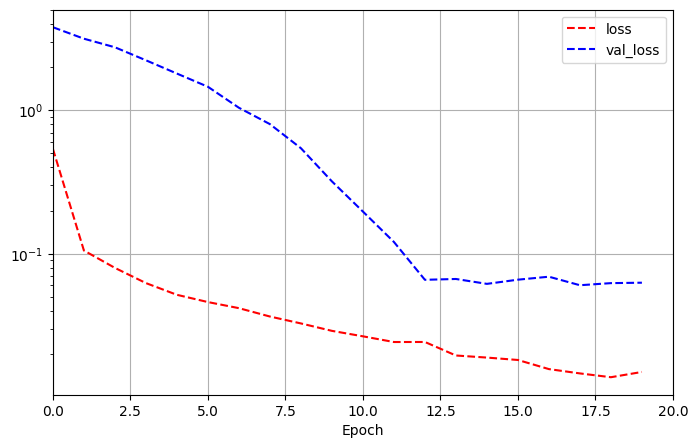

In [68]:
pd.DataFrame(CNN_hist.history).plot(
figsize=(8, 5), xlim=[0, 20], logy=True, grid=True, xlabel="Epoch",
 style=["r--", "b--"])
plt.show()

In [ ]:
results= model.evaluate(test_set)
print(results)
pred=model.predict(test_features[:10,:])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1800
0.1770588904619217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


In [ ]:
print(pred)
print(test_labels['LOGG'][:10])

[[0.3328795]
 [1.2301332]
 [2.5309465]
 [1.0576134]
 [2.349802 ]
 [2.6782405]
 [2.1213315]
 [0.8489586]
 [2.2309725]
 [1.0403563]]
[0.920775   1.074224   2.398953   0.8708589  2.4270613  2.4898858
 2.403348   0.85261536 2.808398   0.9820859 ]


# VAE
Let's make two VAEs trying either only feed-forward layers or only conv1d layers.

In [ ]:
class Sampling(tf.keras.layers.Layer): #Custom Layer for sampling a Gaussian distribution from latent space
  def call(self, inputs):
    mean, log_var = inputs
    return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

The VAEloss below is derived from optimizing the model parameters such that when we sample from the Normally distributed coding space, the decoder's output matches our encoder's input. See https://arxiv.org/pdf/1606.05908


In [1]:
class VAELoss(tf.keras.layers.Layer): #Dummy layer to add the new latent loss with the ordinary reconstruction loss
  def call(self, inputs):
    codings_mean, codings_log_var = inputs
    latent_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1))/shape
    self.add_loss(latent_loss)
    return inputs

NameError: name 'tf' is not defined

In [71]:
inputs = tf.keras.layers.Input(shape=[mfeat])
Z = tf.keras.layers.Dense(200, activation="relu")(inputs)
#Z = tf.keras.layers.Dense(150, activation="relu")(Z)


In [72]:
Z.add(tf.keras.layers.Dense(150, activation="relu"))

AttributeError: 'KerasTensor' object has no attribute 'add'

In [ ]:
codings_size=10
def gen_encoder(model,codings_size):
inputs = tf.keras.layers.Input(shape=[mfeat])
Z = tf.keras.layers.Dense(200, activation="relu")(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z) # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z) # γ
codings_mean, codings_log_var = VAELoss()([codings_mean, codings_log_var])
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
 inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [ ]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(150, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(200, activation="relu")(x)
outputs = tf.keras.layers.Dense(shape)(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [ ]:
codings_mean, codings_log_var, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=reconstructions)

In [ ]:
variational_ae.compile(loss="mse", optimizer="nadam")
history = variational_ae.fit(train_features,train_features, epochs=25, batch_size=128,
 validation_data=(valid_features, valid_features))

Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 0.6272 - val_loss: 0.0918
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0785 - val_loss: 0.0671
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0562 - val_loss: 0.0426
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0388 - val_loss: 0.0250
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0231 - val_loss: 0.0235
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0261 - val_loss: 0.0300
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 0.0251 - val_loss: 0.0162
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.0157 - val_loss: 0.0146
Epoch 9/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0147 - val_loss: 0.0135
Epoch 10/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0193 - val_loss: 0.0196
Epoch 11/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0169 - val_loss: 0.0134
Epoch 12/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0131 - val_loss: 

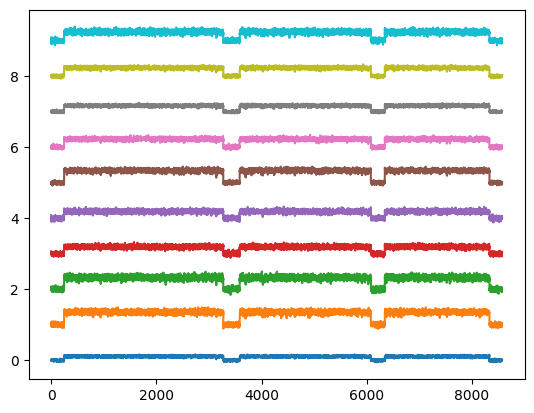

In [ ]:
testcode=tf.random.normal(shape=[10,codings_size])
gen_spec=variational_decoder(testcode).numpy()
for i in range(10):
    plt.plot(gen_spec[i,:] + i)

In [ ]:
model.predict(gen_spec)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[14841.326 ],
       [ 7596.0747],
       [38172.125 ],
       [57232.25  ],
       [ 8018.194 ],
       [-3671.9214],
       [20970.639 ],
       [ 3526.312 ],
       [19970.482 ],
       [19779.58  ]], dtype=float32)

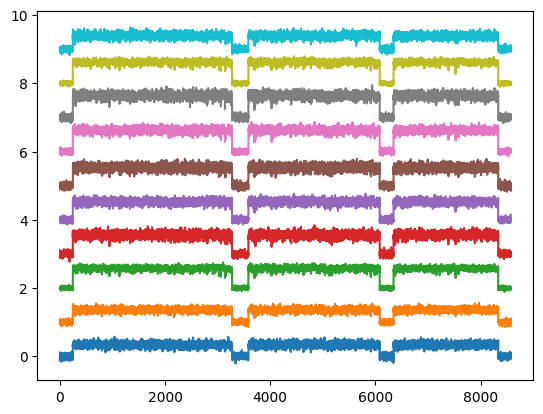

In [ ]:
testcode=tf.random.normal(shape=[10,codings_size])
gen_spec=variational_decoder(testcode).numpy()
for i in range(10):
    plt.plot(gen_spec[i,:] + i)

In [ ]:
model.predict(gen_spec)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[  5635.307 ],
       [-10723.739 ],
       [ -4886.3315],
       [-51270.527 ],
       [ 16775.348 ],
       [-18735.861 ],
       [ 20798.771 ],
       [ 21724.803 ],
       [ 24850.08  ],
       [ 21900.115 ]], dtype=float32)

In [ ]:
test_labels['LOGG']

array([0.920775  , 1.074224  , 2.398953  , 0.8708589 , 2.4270613 ,
       2.4898858 , 2.403348  , 0.85261536, 2.808398  , 0.9820859 ,
       1.7071176 , 0.9888453 , 1.8631136 , 2.3819761 , 1.1506026 ,
       2.3937106 , 2.7396674 , 0.9985979 , 2.4660876 , 2.5334022 ,
       2.7651834 , 2.4789896 , 2.376651  , 2.6510518 , 2.4435108 ,
       0.8125447 , 0.9637552 , 2.565066  , 0.78283757, 2.8601446 ,
       1.6429863 , 2.3806643 , 0.7937472 , 0.7015706 , 1.2598863 ,
       2.0954225 , 1.9027402 , 2.7980857 , 2.9164412 , 2.4822764 ,
       0.42711002, 2.8716419 , 2.6164486 , 0.8161989 , 1.1576412 ,
       1.5726635 , 2.3743868 , 2.5045593 , 2.533553  , 2.576993  ,
       1.9328728 , 2.379281  , 1.5605392 , 2.5162978 , 2.0135586 ,
       1.4398739 , 2.4719586 , 1.8842878 , 1.3831518 , 2.6328893 ,
       2.6606858 , 2.400342  , 2.0852134 , 2.547438  , 2.5301025 ,
       1.9815438 , 0.96867734, 2.4709187 , 2.975101  , 2.2473483 ,
       2.5646586 , 2.2468753 , 2.4397943 , 2.457472  , 1.99680